In [1]:
using Plots

## Implementación del método de Euler

#### 1 - Especificación del problema a resolver

Queremos simular numéricamente la evolución de sistemas modelados por 
ecuaciones diferenciales ordinarias (EDOs) de dimensión $d\geq 1$ de la forma

<a id='Edo-Compacta'></a>
\begin{equation*}
\frac{d}{dt} u = f(t,u,p). \hspace{10em} \tag{1}
\end{equation*}

donde $u =(u^1,\ldots,u^d) \in \mathbb{R}^d$ es el _vector de estado_ del sistema, y $p \in \mathbb{R}^m$ es un vector de parámetros constantes del sistema.

Sabemos que, fijado el vector $p$ de parámetros constantes, 
dados $t_0 \in \mathbb{R}$ y $u_0 =(u^1_0,\ldots,u^d_0) \in \mathbb{R}^d$, existe una única solución $u(t)$ de [(1)](#Edo-Compacta) que satisfaga la condición inicial

<a id='Cond-Ini'></a>
\begin{equation*}
  u(t_0)=u_0. \hspace{12em} \tag{2}
\end{equation*}

En la práctica, nos interesará calcular de forma aproximada la solución $u(t)$ para un cierto intervalo temporal $t \in [t_0,T]$.

Para definir un problema de valor inicial, haremos uso del la siguiente estructura (tipo compuesto) de Julia.

In [3]:
struct ProblemaEDO
    f::Function
    u0::Vector{Float64}
    tspan::Tuple{Float64,Float64}
    p::Vector{Float64}
end

El campo f no necesitan explicación adicional. 
El campo tspan representa el intervalo temporal $[t_0,T]$ guardado como una tupla de dos componentes, es decir, el par ordenado $(t_0,T)$. Las componentes de los arrays guardados en los campos u0 y p, así como los de tspan, los definimos como Float64. 

 La solución $u(t)$ del problema de valor inicial (1)--(2)) se aproximará para una discretización del tiempo obtenida de dividir el intervalo temporal $[t_0,T]$ en $n$ partes iguales. Es decir,  se tomará los valores discretos del tiempo $t_0,t_1,t_2,\ldots,t_{n-1},t_n=T$, donde $t_k=t_{0}+k (T-t_0)/n$, y se calcularán las aproximaciones 
$u_k =(u^1_k,\ldots,u^d_k) \approx u(t_k)$ para $k=0,1,\ldots,n$. Representaremos dicha solución aproximada discreta como una instancia del siguiente tipo compuesto de Julia.

In [4]:
struct SolucionProblemaEDO
    t::Vector{Float64}
    u::Vector{Vector{Float64}}
    prob::ProblemaEDO
end

Si sol es una instancia del tipo compuesto SolucionProblemaEDO, en sol.u[1] tendremos $u_0$, $u_1$ en sol.u[2], $u_2$ en sol.u[3], etc. En cambio, para $j=1,\ldots,n$, tendremos $t_{j-1}$ en sol.t[j]. Finalmente, en sol.prob se tendrá el problema de valor inicial el cual es solución sol.

Así, una vez que se hayan calculado las aproximaciones $u_j \approx u(t_j)$ correspondiente al problema prob::ProblemaEDO, si tt es un array que contiene los tiempos $t_0,t_1,\ldots,t_n$, y uu es un array que contiene las aproximaciones  $u_0,u_1,\ldots,u_n$, la instancia sol de SolucionProblemaEDO correspondiente se construirá con SolucionProblemaEDO(tt,uu,prob).

#### 2- Implementación del método de Euler

 Seguidamente, definimos una función (que llamaremos Euler) que toma como argumentos de entrada  el problema prob, y los enteros positivos $n$ y $m$. El argumento $m$ tomará como valor por defecto $m=1$.

Si $m=1$, ello indicará que para cada $j=1,\ldots,n$, se obtendrá la aproximación $u_j \approx u(t_j)$ aplicando un paso de longitud $h=(T-t_0)/n$ del método de Euler, es decir, para $j=0,1,\ldots,n-1$,

\begin{equation*}
     u_{j+1} = u_{j} + h \, f\left(t_{j}, u_{j}, p\right).
\end{equation*}






En cambio, si $m>1$, cada aproximación $u_j \approx u(t_j)$ se obtendrá aplicando $m$ pasos de longitud $h=(T-t_0)/(n m)$ del método de Euler. Cuando se invoca a la función como Euler(prob,n), se interpretará como Euler(prob,n,1).

In [5]:
function  Euler(problema::ProblemaEDO,n,m=1)
    # n: número de soluciones/vectores de estado a calcular
    # m: cada cuántos steps se guarda un vector de estado para el cálculo final
    # En funcion de n y m se calcula h -> 
    #      h: Intervalo de tiempo entre cada una de las soluciones guardadas (si m = 1).
    #         Si no, el intervalo de tiempo entre cada una de las soluciones es h * m
    
    u0   = problema.u0    # Vector de la solución inicial
    t0,T = problema.tspan # Intervalo de tiempo para calcular la solución aproximada
    p    = problema.p     # Vector de parámetros constantes
    f    = problema.f     # Función de modelado del problema | Ecuación diferencial a resolver (en formato vectorial)
    
    h = (T-t0)/(n*m) # Intervalo de tiempo entre cada una de las soluciones
    tt = [t0]        # Vector de tiempos
    uu = [u0]        # Vector de estados
    
    tj = t0 # Inicializar el instante inicial
    uj = u0 # Inicializar el vector de estado inicial
    
    for j in 1:n
        # Para cada solución que queremos guardar
        for i in 1:m
            # Avanzamos m steps en el método de Euler
             uj += h * f(tj, uj, p)
             tj += h
        end
        # Guardamos t y u
        push!(tt,tj)
        push!(uu,uj)
    end
    return SolucionProblemaEDO(tt,uu,problema)
  end



Euler (generic function with 2 methods)


La función Euler devuelve como argumento de salida un objeto sol de tipo SolucionProblemaEDO: el campo sol.t tiene el array $[t_0,\ldots,t_n]$ donde $t_k = t_0 + k \, h$, $h=(T-t_0)/n$, y sol.u tiene el array de vectores de estado

\begin{eqnarray*}
     \begin{array}{ccc}
   [u^1_0 & \cdots& u^d_0] \\
   [u^1_1 & \cdots& u^d_1]  \\
  \vdots & \vdots& \vdots \\
      [u^1_n & \cdots& u^d_n]
     \end{array}
\end{eqnarray*} 

donde $u_k  = (u^1_k,\ldots,u^d_k) \in \mathbb{R}^d$ ($k=1\ldots,n$) son aproximaciones de $u(t_k)$ que se han obtenido aplicando el método Euler al sistema  [(1)](#Edo-Compacta) con la condición inicial  [(2)](#Cond-Ini), con longitud de paso $h=(T-t_0)/(n m)$. 

#### 3 - Aplicación al problema presa-depredador con caza periódica

In [6]:
function f(t,u,p)
    # Variables de estado
    v = u[1]
    w = u[2]

    # Parámetros constantes del sistema
    a = p[1]
    b = p[2]
    c = p[3]
    d = p[4]
    
    # Componente de caza (comopente externo sistema no autónomo)
    gt = 1/20 * (sin(π*t/12))^2

    # Devolvemos: [(población de alces), (Población de lobos)]
    return [(a-b*w - gt) * v, (c*v-d) * w]
end

f (generic function with 1 method)

Consideremos la solución $u(t)=(v(t),w(t))$ de [(1)](#Edo-LV) con los datos iniciales $v(0)=510$, $w(0)=33$, para el intervalo temporal $t \in [0,30]$.

In [7]:
p     = [1.,1/50,3/1000,1.]
u0    = [510., 33.]
tspan = (0.,30.)
prob  = ProblemaEDO(f,u0,tspan,p)

ProblemaEDO(Main.f, [510.0, 33.0], (0.0, 30.0), [1.0, 0.02, 0.003, 1.0])

In [11]:
n    = 10000
m    = 100
sol  = Euler(prob,n,m)
sol_ = Euler(prob,n,2m);

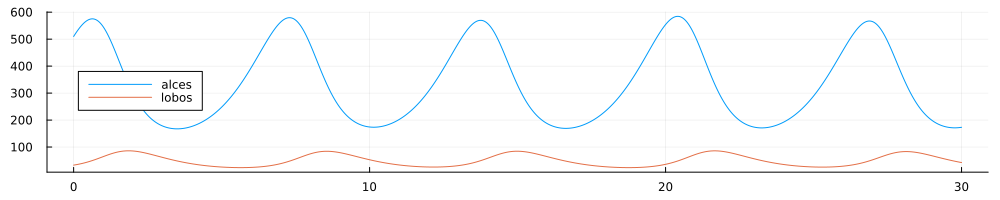

In [12]:
tt = sol.t
vv = [u[1] for u in sol.u]
ww = [u[2] for u in sol.u]

plot(tt,[vv,ww], xlabel="t",label=["alces" "lobos"], legend=:left, size=(1000,200))


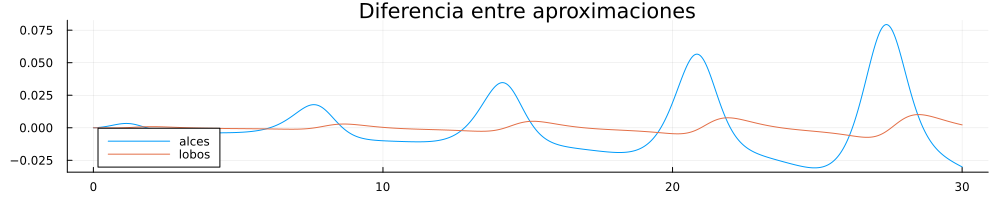

In [13]:

vv_ = [u[1] for u in sol_.u]
ww_ = [u[2] for u in sol_.u]

plot(tt,[vv-vv_,ww-ww_], title="Diferencia entre aproximaciones", xlabel="t",label=["alces" "lobos"], legend=:bottomleft, size=(1000,200))


#### 4 - Implementación más genérica del método de Euler

Para definir un problema de valor inicial, haremos uso del la siguiente estructura (tipo compuesto) **parametrizada** de Julia

In [11]:
struct ProblemaEDOs{ftype,fltype}
    f::ftype
    u0::Vector{fltype}
    tspan::Tuple{fltype,fltype}
    p::Vector{fltype}
end

Las componentes de los arrays guardados en los campos u0 y p, así como los de tspan, deben ser de un tipo común de datos fltype. En nuestros cálculos, habitualmente serán de tipo Float64, y cuando nos haga falta más precisión, serán de tipo BigFloat.
 
 
 Representaremos las soluciones aproximadas discretas como una instancia del siguiente tipo compuesto parametrizado de Julia.

In [12]:
struct SolucionProblemaEDOs{ftype,fltype}
    t::Vector{fltype}
    u::Vector{Vector{fltype}}
    prob::ProblemaEDOs{ftype,fltype}
end

Si sol es una instancia del tipo compuesto SolucionProblemaEDOs, en sol.u[1] tendremos $u_0$, $u_1$ en sol.u[2], $u_2$ en sol.u[3], etc. En cambio, para $j=1,\ldots,n$, tendremos $t_{j-1}$ en sol.t[j]. Finalmente, en sol.prob se tendrá el problema de valor inicial el cual es solución sol.

Así, una vez que se hayan calculado las aproximaciones $u_j \approx u(t_j)$ correspondiente al problema prob::ProblemaEDOs, si tt es un array que contiene los tiempos $t_0,t_1,\ldots,t_n$, y uu es un array que contiene las aproximaciones  $u_0,u_1,\ldots,u_n$, la instancia sol de SolucionProblemaEDOs correspondiente se construirá con SolucionProblemaEDOs(tt,uu,prob).

In [13]:
function  Euler(problema::ProblemaEDOs{ftype,fltype},n,m=1) where {ftype<:Function,fltype<:AbstractFloat}
    
    u0=problema.u0
    t0,T=problema.tspan
    p=problema.p
    f=problema.f
    #
    
    h = (T-t0)/(n*m)   
    tt =  [t0]
    uu = [u0]
    
    tt[1] = t0
    uu[1] = u0
    tj = t0
    uj = u0
    for j in 1:n
        for i in 1:m    
         uj += h * f(tj, uj, p)
         tj += h
        end
         push!(tt,tj)
         push!(uu,uj)
    end
    return SolucionProblemaEDOs(tt,uu,problema)
  end

Euler (generic function with 4 methods)

#### 5-Propagación de los errores de redondeo

Para obtener una estimación de la propagación de los errores de redondeo, realizaremos una simulación adicional en una aritmética de coma flotante de mayor precisión.

In [14]:
U0 = BigFloat.(u0)
Tspan = BigFloat.(tspan)
P = BigFloat.(p) 
Prob = ProblemaEDOs(f,U0,Tspan,P)

Sol = Euler(Prob,n,m);

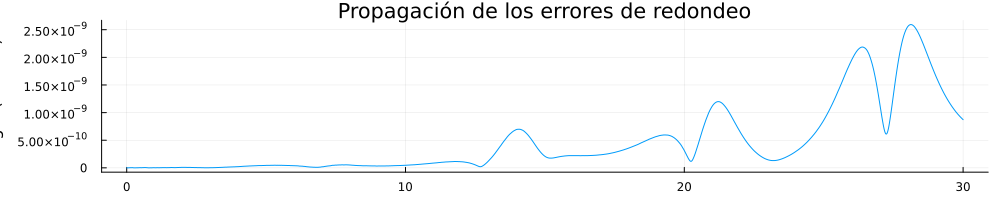

In [15]:
TT = Sol.t
VV = [u[1] for u in Sol.u]
WW = [u[2] for u in Sol.u]

errores = @. sqrt((vv-VV)^2 + (ww-WW)^2)

plot(tt, errores, title="Propagación de los errores de redondeo", 
                          xlabel="t", ylabel="log10(errores)", legend=false, size=(1000,200))